# Feature Selection and Feature Engineering

We want to do our best to make good predictions by creating good models. One way we can improve our model is to consider the data's feature and either specifically _select_ features (**feature selection**) and/or _create new features_ (called **feature engineering**)

# Learning Objectives

- Use correlations and other algorithms to inform feature selection
- Address the problem of multicollinearity in regression problems
- Create new features for use in modeling
    - Use `PolynomialFeatures` to build compound features

In [1]:
# Initial imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Feature Selection

New dataset for today! Insurance costs

My source: https://www.kaggle.com/mirichoi0218/insurance (they got the idea for cleaning up the original open source data from [Machine Learning with R](https://www.packtpub.com/product/machine-learning-with-r-third-edition/9781788295864))

Target: `charges`

In [2]:
# Read in the data
df = pd.read_csv('data/insurance.csv')

In [3]:
# explore the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


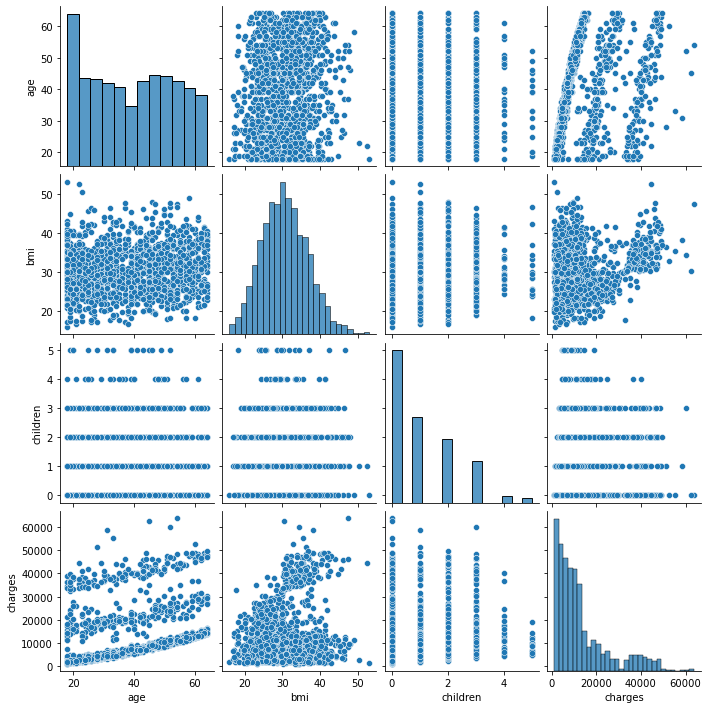

In [4]:
# visualize relationships between numeric columns
sns.pairplot(df);

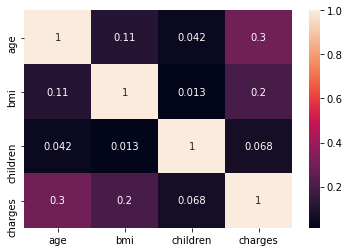

In [5]:
# visualize correlations between numeric columns
sns.heatmap(df.corr(), annot=True);

#### Observations?

- 


In [12]:
df.describe(include=['O'])

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


### First Things First - Train Test Split!

In [6]:
# Import train test split
from sklearn.model_selection import train_test_split

In [7]:
# Define our X and y
X = df.drop(columns='charges')
y = df['charges']

In [8]:
# Train test split
# Use test_size=0.25, random_state=42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [13]:
X_train.describe(include=['O'])

,sex,smoker,region
count,1003,1003,1003
unique,2,2,4
top,male,no,southeast
freq,506,797,259


In [14]:
X_test.describe(include=['O'])

,sex,smoker,region
count,335,335,335
unique,2,2,4
top,male,no,southeast
freq,170,267,105


### Need to Encode!

In [9]:
# Import our One Hot Encoder
from sklearn.preprocessing import OneHotEncoder
# Going to use ColumnTransformer to encode only cat cols
from sklearn.compose import ColumnTransformer

In [10]:
# Which columns are categoricals?
# Handy trick!
cat_cols = [c for c in df.columns if df[c].dtype == 'O']
cat_cols

['sex', 'smoker', 'region']

In [50]:
# create an encoder object. This will help us to convert
# categorical variables to new columns
encoder = OneHotEncoder(handle_unknown='error',
                        drop='first', # leaves all 4 regions, creating 4 new columns for region
                        categories='auto')

# Create an columntransformer object.
# This will help us to merge transformed columns
# with the rest of the dataset.

ct = ColumnTransformer(transformers=[('ohe', encoder, cat_cols)],
                       remainder='passthrough')
ct.fit(X_train)
X_train_enc = ct.transform(X_train)
X_test_enc = ct.transform(X_test)

In [51]:
X_train_enc

array([[ 1.   ,  0.   ,  1.   , ..., 24.   , 23.655,  0.   ],
       [ 0.   ,  0.   ,  0.   , ..., 28.   , 26.51 ,  2.   ],
       [ 1.   ,  0.   ,  0.   , ..., 51.   , 39.7  ,  1.   ],
       ...,
       [ 1.   ,  0.   ,  0.   , ..., 58.   , 25.175,  0.   ],
       [ 0.   ,  1.   ,  0.   , ..., 37.   , 47.6  ,  2.   ],
       [ 1.   ,  0.   ,  0.   , ..., 55.   , 29.9  ,  0.   ]])

In [52]:
# can display as a dataframe like so
X_train_enc = pd.DataFrame(X_train_enc, columns= ct.get_feature_names())
X_train_enc.head(10)

,ohe__x0_male,ohe__x1_yes,ohe__x2_northwest,ohe__x2_southeast,ohe__x2_southwest,age,bmi,children
0,1.0,0.0,1.0,0.0,0.0,24.0,23.655,0.0
1,0.0,0.0,0.0,1.0,0.0,28.0,26.510,2.0
2,1.0,0.0,0.0,0.0,1.0,51.0,39.700,1.0
3,1.0,1.0,0.0,1.0,0.0,47.0,36.080,1.0
4,0.0,0.0,0.0,0.0,1.0,46.0,28.900,2.0
5,0.0,0.0,1.0,0.0,0.0,63.0,26.220,0.0
6,0.0,0.0,0.0,0.0,0.0,38.0,19.950,2.0
7,0.0,0.0,1.0,0.0,0.0,28.0,26.315,3.0
8,1.0,0.0,0.0,0.0,1.0,25.0,26.800,3.0
9,0.0,0.0,0.0,0.0,0.0,18.0,30.115,0.0


### Now To Scale!

In [53]:
# Import our scaler
from sklearn.preprocessing import StandardScaler
# intstantiate our scaler
scaler = StandardScaler()

# train on train data
scaler.fit(X_train_enc)

# transform both train and test data
X_train_scaled = scaler.transform(X_train_enc)
X_test_scaled = scaler.transform(X_test_enc)

In [54]:
pd.DataFrame(X_train_scaled, columns= ct.get_feature_names())

,ohe__x0_male,ohe__x1_yes,ohe__x2_northwest,ohe__x2_southeast,ohe__x2_southwest,age,bmi,children
0,0.991067,-0.508399,1.754205,-0.590015,-0.571594,-1.087167,-1.140875,-0.917500
1,-1.009014,-0.508399,-0.570059,1.694871,-0.571594,-0.802106,-0.665842,0.743605
2,0.991067,-0.508399,-0.570059,-0.590015,1.749494,0.836992,1.528794,-0.086947
3,0.991067,1.966960,-0.570059,1.694871,-0.571594,0.551932,0.926476,-0.086947
4,-1.009014,-0.508399,-0.570059,-0.590015,1.749494,0.480667,-0.268178,0.743605
...,...,...,...,...,...,...,...,...
998,-1.009014,-0.508399,-0.570059,-0.590015,-0.571594,-1.514757,0.139468,2.404710
999,-1.009014,-0.508399,-0.570059,1.694871,-0.571594,-0.018189,-1.105101,3.235263
1000,0.991067,-0.508399,-0.570059,-0.590015,-0.571594,1.335848,-0.887967,-0.917500
1001,-1.009014,1.966960,-0.570059,-0.590015,1.749494,-0.160720,2.843247,0.743605


### And let's model!

In [55]:
# Import our linear regression function
from sklearn.linear_model import LinearRegression
# instantiate
lr = LinearRegression()

# fit
lr.fit(X_train_scaled, y_train)

# grab predictions for train and test set
train_preds = lr.predict(X_train_scaled)
test_preds = lr.predict(X_test_scaled)

In [56]:
lr.coef_

array([  22.81029539, 9546.25195286, -152.80047116, -341.97255581,
       -370.63084494, 3643.06598197, 2042.26503648,  513.51689408])

In [57]:
# evaluate
from sklearn.metrics import r2_score, mean_squared_error

r2_score(y_train, train_preds)

0.7449555328228536

In [58]:
r2_score(y_test, test_preds)

0.7672642952734356

In [59]:
# !conda install -c districtdatalabs yellowbrick

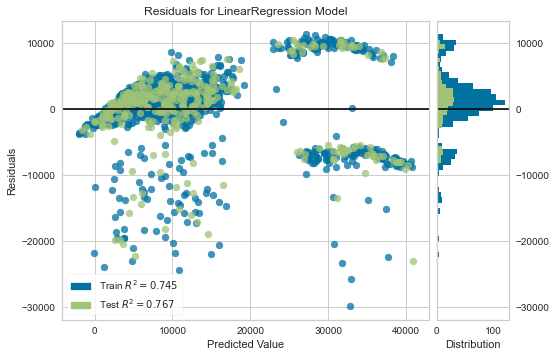

In [60]:
# visualizing our residuals 
# https://www.scikit-yb.org/en/latest/api/regressor/residuals.html
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(lr)

visualizer.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
visualizer.show()  
plt.show()

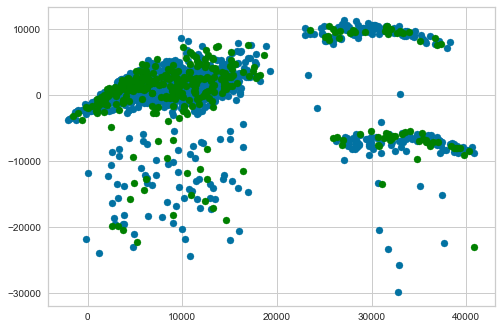

In [61]:
# Basically the same as
plt.scatter(train_preds, (train_preds-y_train))
plt.scatter(test_preds, (test_preds-y_test), color='green');

Ideas to continue improving this model?

- 


## Feature Importance through Coefficients

Because we've scaled our data, we can explore our coefficients to see which are having more of an impact on our model.

Note! This, or using p-values from a statsmodels model, is all you're expected to do in this project!

In [62]:
# Let's make our scaled training data a df, for ease of use
X_train_scaled = pd.DataFrame(X_train_scaled, columns=ct.get_feature_names())
X_train_scaled.head()

,ohe__x0_male,ohe__x1_yes,ohe__x2_northwest,ohe__x2_southeast,ohe__x2_southwest,age,bmi,children
0,0.991067,-0.508399,1.754205,-0.590015,-0.571594,-1.087167,-1.140875,-0.917500
1,-1.009014,-0.508399,-0.570059,1.694871,-0.571594,-0.802106,-0.665842,0.743605
2,0.991067,-0.508399,-0.570059,-0.590015,1.749494,0.836992,1.528794,-0.086947
3,0.991067,1.966960,-0.570059,1.694871,-0.571594,0.551932,0.926476,-0.086947
4,-1.009014,-0.508399,-0.570059,-0.590015,1.749494,0.480667,-0.268178,0.743605


In [63]:
# Same with X_test_scaled
X_test_scaled = pd.DataFrame(X_test_scaled, columns=ct.get_feature_names())

In [64]:
# Check the coefficients
lr.coef_

array([  22.81029539, 9546.25195286, -152.80047116, -341.97255581,
       -370.63084494, 3643.06598197, 2042.26503648,  513.51689408])

In [65]:
# look at the coefficients with the names of each col
dict(zip(X_train_scaled.columns, lr.coef_))

{'ohe__x0_male': 22.810295392038203,
 'ohe__x1_yes': 9546.251952862482,
 'ohe__x2_northwest': -152.800471156434,
 'ohe__x2_southeast': -341.9725558148871,
 'ohe__x2_southwest': -370.6308449356975,
 'age': 3643.0659819652296,
 'bmi': 2042.2650364763738,
 'children': 513.5168940844046}

In [43]:
# sns.heatmap(X_train_scaled.corr(), annot=True);

In [44]:
# Let's model again using only the 3 strongest coefficients
used_cols = ['ohe__x2_southeast', 'ohe__x1_yes', 'age']

In [46]:
lr_subset = LinearRegression()

lr_subset.fit(X_train_scaled[used_cols], y_train)

LinearRegression()

In [47]:
lr_subset.score(X_train_scaled[used_cols], y_train)

0.7166850995693387

In [48]:
lr_subset.score(X_test_scaled[used_cols], y_test)

0.7368844208715093

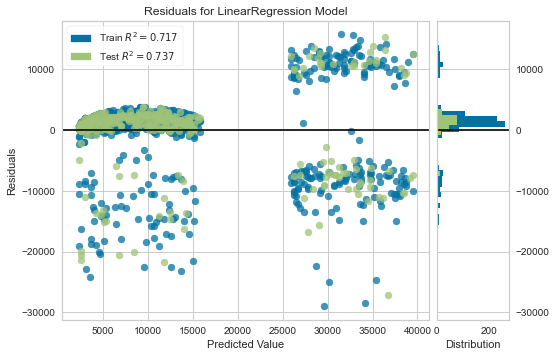

In [49]:
# visualizing our residuals
# https://www.scikit-yb.org/en/latest/api/regressor/residuals.html

visualizer = ResidualsPlot(lr_subset)

visualizer.fit(X_train_scaled[used_cols], y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_scaled[used_cols], y_test)  # Evaluate the model on the test data
visualizer.show()  
plt.show()

#### Evaluate

- 


# Feature Engineering

## Interaction Terms

When do we need interaction terms? And how do we check for them?

Well, first things first - what interactions do _you_ think would make sense? That's the easiest way to incorporate interaction terms - use domain knowledge to think through what usefully could be combined into an interaction.

As for how to check if something might be better captured as an interaction...

In [69]:
X_train_enc

,ohe__x0_male,ohe__x1_yes,ohe__x2_northwest,ohe__x2_southeast,ohe__x2_southwest,age,bmi,children
0,1.0,0.0,1.0,0.0,0.0,24.0,23.655,0.0
1,0.0,0.0,0.0,1.0,0.0,28.0,26.510,2.0
2,1.0,0.0,0.0,0.0,1.0,51.0,39.700,1.0
3,1.0,1.0,0.0,1.0,0.0,47.0,36.080,1.0
4,0.0,0.0,0.0,0.0,1.0,46.0,28.900,2.0
...,...,...,...,...,...,...,...,...
998,0.0,0.0,0.0,0.0,0.0,18.0,31.350,4.0
999,0.0,0.0,0.0,1.0,0.0,39.0,23.870,5.0
1000,1.0,0.0,0.0,0.0,0.0,58.0,25.175,0.0
1001,0.0,1.0,0.0,0.0,1.0,37.0,47.600,2.0


In [70]:
# add the target back onto our OHE df
# note the index difference...
train_df = X_train_enc.copy()
train_df['target'] = y_train.reset_index(drop=True)
train_df

,ohe__x0_male,ohe__x1_yes,ohe__x2_northwest,ohe__x2_southeast,ohe__x2_southwest,age,bmi,children,target
0,1.0,0.0,1.0,0.0,0.0,24.0,23.655,0.0,2352.96845
1,0.0,0.0,0.0,1.0,0.0,28.0,26.510,2.0,4340.44090
2,1.0,0.0,0.0,0.0,1.0,51.0,39.700,1.0,9391.34600
3,1.0,1.0,0.0,1.0,0.0,47.0,36.080,1.0,42211.13820
4,0.0,0.0,0.0,0.0,1.0,46.0,28.900,2.0,8823.27900
...,...,...,...,...,...,...,...,...,...
998,0.0,0.0,0.0,0.0,0.0,18.0,31.350,4.0,4561.18850
999,0.0,0.0,0.0,1.0,0.0,39.0,23.870,5.0,8582.30230
1000,1.0,0.0,0.0,0.0,0.0,58.0,25.175,0.0,11931.12525
1001,0.0,1.0,0.0,0.0,1.0,37.0,47.600,2.0,46113.51100


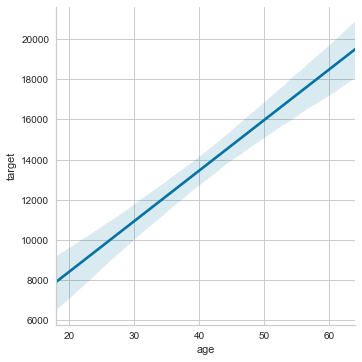

In [77]:
sns.lmplot(x='age', y='target', data=train_df, scatter=False)

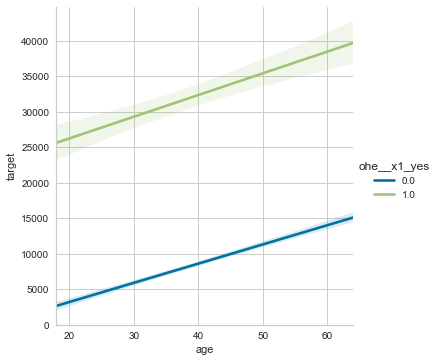

In [71]:
# an example of no interaction term...
sns.lmplot(x='age', y='target', hue='ohe__x1_yes', data=train_df, scatter=False)
plt.show()

How do I know these two variables, `age` and `smoker_yes`, aren't interacting? 

- Look at the slopes - parallel


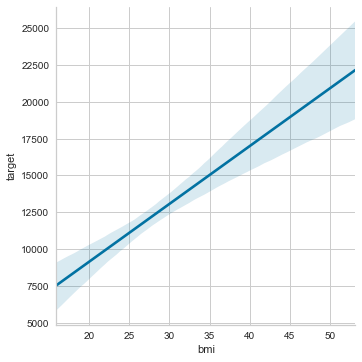

In [76]:
sns.lmplot(x='bmi', y='target', data=train_df, scatter=False);

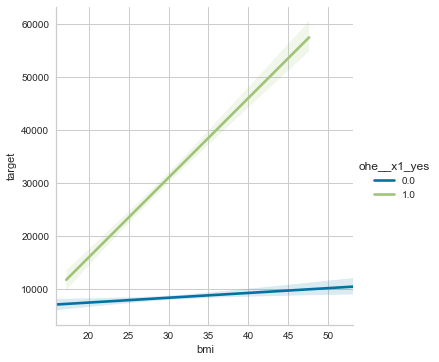

In [72]:
# now let's look at something else...
sns.lmplot(x='bmi', y='target', hue='ohe__x1_yes', data=train_df, scatter=False)
plt.show()

What do you think?

- 


## Polynomial Features

Instead of just multiplying features at random, we might consider trying **every possible product of features**. That's what PolynomialFeatures does.


https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

Demonstrating this on a toy example, with a single x variable predicting y.

In [78]:
# 150 samples from uniform distribution between -2pi and 2pi

x = np.random.uniform(-2*np.pi, 2*np.pi, 150)

# Creating target (y) - so we know the true relationship between x and y
# But - adding some noise (error) with 'np.random'

y = np.sin(x) + np.random.normal(loc=0, scale=0.4, size=len(x))

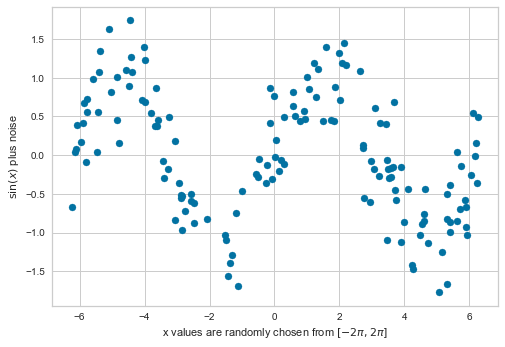

In [79]:
# Visualize it
plt.scatter(x, y)

plt.ylabel('$\sin(x)$ plus noise')
plt.xlabel('x values are randomly chosen from $[-2\pi, 2\pi]$')
plt.show()

In [80]:
# Fitting a linear model
lr = LinearRegression()
lr.fit(x.reshape(-1, 1), y)

LinearRegression()

In [81]:
# Grabbing the predicted values
y_pred = lr.predict(x.reshape(-1, 1))

In [82]:
# Scoring our model
lr.score(x.reshape(-1, 1), y)

0.13655527647913457

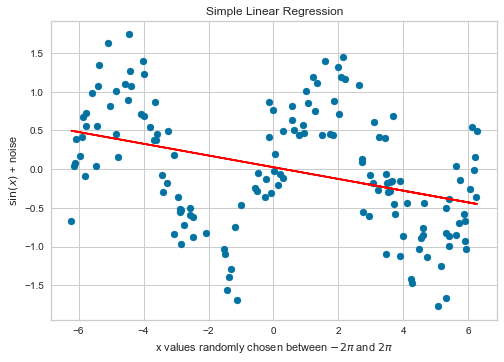

In [83]:
# Visualize it
plt.scatter(x, y) # original data

plt.plot(x, y_pred, c='red') # predicted values

plt.ylabel('$\sin(x)$ + noise')
plt.xlabel('x values randomly chosen between $-2\pi$ and $2\pi$')
plt.title("Simple Linear Regression")

plt.show()

Is this a good model? Well - of course not. It's definitely **underfit** - it is not complex enough to accurately capture the pattern and predict the target.

Let's try again, but now with polynomials!

In [84]:
# Import polynomial features
from sklearn.preprocessing import PolynomialFeatures

In [85]:
# For this, we'll need some helper functions
# Shoutout to Andy for sending me these

def create_poly_dataset(x, degree):
    """
    returning dataset with the given polynomial degree
    """
    # Instantiate the PolynomialFeatures object with given 'degree'
    poly = PolynomialFeatures(degree=degree)

    # Now transform data to create higher order features
    new_data = poly.fit_transform(x.reshape(-1, 1))
    return new_data

def fit_linear_model(data, y):
    """
    fitting a linear model and printing model details
    """
    np.set_printoptions(precision=4, suppress=True)

    if data.ndim == 1:
        data = data.reshape(-1, 1)

    lr = LinearRegression(fit_intercept=False)
    lr.fit(data, y)
    print("-"*13)
    print("Coefficients: ", lr.coef_)
    y_pred = lr.predict(data)
    print(f"R-Squared: {lr.score(data, y):.3f}")
    return lr

def plot_predict(x, y, model):
    """
    plotting predictions against true values
    """
    plt.scatter(x, y, label='true')
    x_pred = np.linspace(x.min(), x.max(), 100)
    
    # visualize beyond this x range by uncommenting below:
#     extra = x.ptp() * .2
#     x_pred = np.linspace(x.min() - extra, x.max() + extra, 100)

    plt.plot(x_pred, model.predict(create_poly_dataset(x_pred, len(model.coef_)-1)),
             label='predicted', c='red')

    if len(model.coef_) == 1:
        plt.title(f"{len(model.coef_) - 1} Polynomial Terms \n (no slope)")
    elif (len(model.coef_) - 1) == 1:
        plt.title(f"{len(model.coef_) - 1} Polynomial Term")
    else:
        plt.title(f"{len(model.coef_) - 1} Polynomial Terms")

    plt.legend()
    plt.show()
    return

-------------
Coefficients:  [0.0014]
R-Squared: 0.000


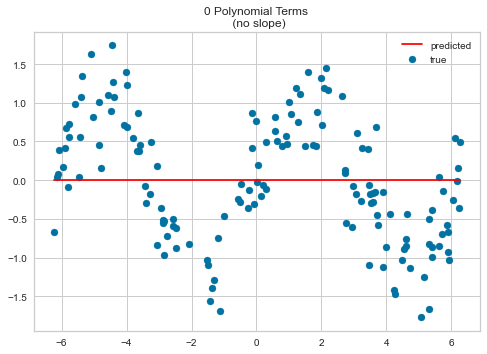

-------------
Coefficients:  [ 0.0252 -0.0757]
R-Squared: 0.137


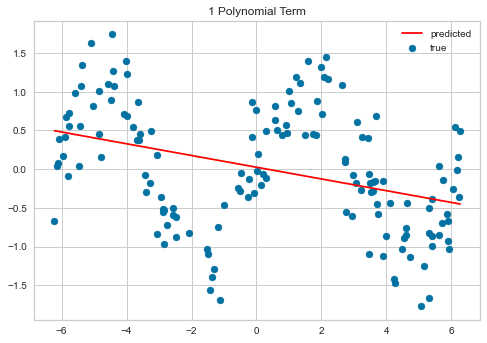

-------------
Coefficients:  [ 0.0772 -0.0751 -0.0035]
R-Squared: 0.140


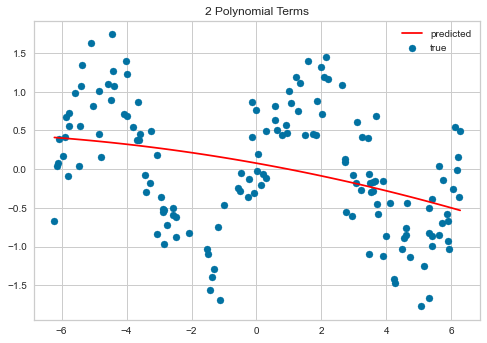

-------------
Coefficients:  [ 0.0535  0.0269 -0.0021 -0.004 ]
R-Squared: 0.182


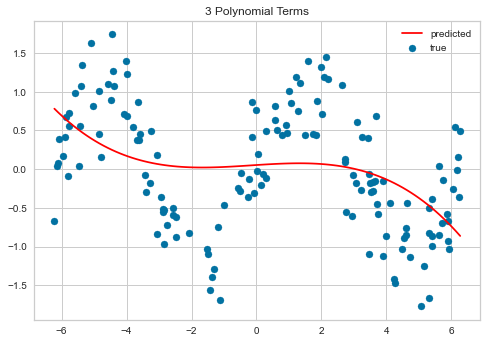

-------------
Coefficients:  [ 0.0036  0.6576  0.001  -0.0742 -0.0001  0.0015]
R-Squared: 0.693


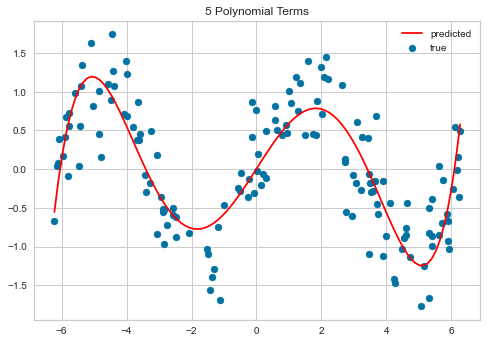

-------------
Coefficients:  [ 0.016   0.9136 -0.0153 -0.1262  0.0012  0.0043 -0.     -0.    ]
R-Squared: 0.739


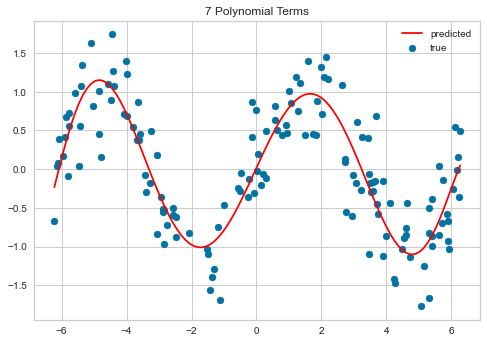

-------------
Coefficients:  [ 0.0677  0.997  -0.0734 -0.1536  0.0092  0.0068 -0.0004 -0.0001  0.
  0.    ]
R-Squared: 0.746


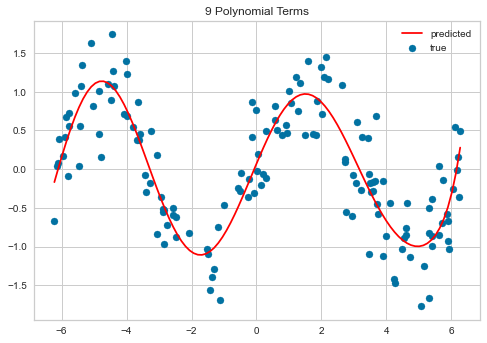

-------------
Coefficients:  [ 0.1197  0.9555 -0.1493 -0.133   0.0239  0.0049 -0.0013 -0.0002  0.
  0.      0.     -0.     -0.      0.    ]
R-Squared: 0.753


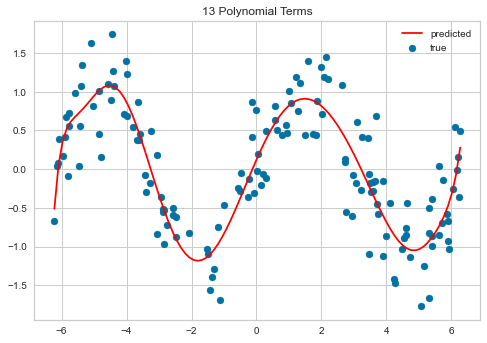

-------------
Coefficients:  [ 0.1962  0.8632 -0.5869 -0.0365  0.3438 -0.0256 -0.0868  0.0041  0.0113
 -0.0003 -0.0008  0.      0.     -0.     -0.      0.      0.     -0.
 -0.    ]
R-Squared: 0.766


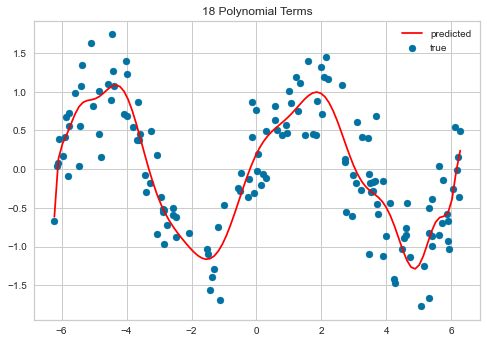

In [86]:
# visualizing an assortment of polynomial degrees
# can visualize each sequential polynomial with `range(n)`
for i in [0, 1, 2, 3, 5, 7, 9, 13, 18]:
    xi = create_poly_dataset(x, i)
    plot_predict(x, y, fit_linear_model(xi, y))

Evaluate: which of these is the best?

- 


Evaluate: so what?

- 


### Now on our dataset

In [118]:
# First all polynomial terms - to degree 3
poly = PolynomialFeatures(degree=3)

In [119]:
# fit that preprocessor
poly.fit(X_train_scaled)

PolynomialFeatures(degree=3)

In [124]:
# transform our training and testing data
X_train_deg3 = poly.transform(X_train_scaled)
X_test_deg3 = poly.transform(X_test_scaled)

In [125]:
# Let's explore our new inputs
X_train_deg3.shape

(1003, 165)

In [123]:
# Make it into a dataframe to more easily see what's happening
deg_3_df = pd.DataFrame(X_train_deg3, 
                        # column names come from the combinations
                        columns=poly.get_feature_names(input_features=X_train_scaled.columns))
# Check out the resulting columns
deg_3_df.columns

Index(['1', 'ohe__x0_male', 'ohe__x1_yes', 'ohe__x2_northwest',
       'ohe__x2_southeast', 'ohe__x2_southwest', 'age', 'bmi', 'children',
       'ohe__x0_male^2',
       ...
       'age^3', 'age^2 bmi', 'age^2 children', 'age bmi^2', 'age bmi children',
       'age children^2', 'bmi^3', 'bmi^2 children', 'bmi children^2',
       'children^3'],
      dtype='object', length=165)

In [126]:
# Interaction-only terms with the same function
# Set interaction_only=True
interactions = PolynomialFeatures(degree=2, interaction_only=True)

In [129]:
# Fit on training data
interactions.fit(X_train_scaled)

# Transform training and testing data
X_train_interactions = interactions.transform(X_train_scaled)
X_test_interactions = interactions.transform(X_test_scaled)

In [131]:
X_train_interactions.shape

(1003, 37)

In [130]:
# Can make into a df to explore
int_df = pd.DataFrame(X_train_interactions,
                      columns=interactions.get_feature_names(input_features=X_train_scaled.columns))
int_df.columns

Index(['1', 'ohe__x0_male', 'ohe__x1_yes', 'ohe__x2_northwest',
       'ohe__x2_southeast', 'ohe__x2_southwest', 'age', 'bmi', 'children',
       'ohe__x0_male ohe__x1_yes', 'ohe__x0_male ohe__x2_northwest',
       'ohe__x0_male ohe__x2_southeast', 'ohe__x0_male ohe__x2_southwest',
       'ohe__x0_male age', 'ohe__x0_male bmi', 'ohe__x0_male children',
       'ohe__x1_yes ohe__x2_northwest', 'ohe__x1_yes ohe__x2_southeast',
       'ohe__x1_yes ohe__x2_southwest', 'ohe__x1_yes age', 'ohe__x1_yes bmi',
       'ohe__x1_yes children', 'ohe__x2_northwest ohe__x2_southeast',
       'ohe__x2_northwest ohe__x2_southwest', 'ohe__x2_northwest age',
       'ohe__x2_northwest bmi', 'ohe__x2_northwest children',
       'ohe__x2_southeast ohe__x2_southwest', 'ohe__x2_southeast age',
       'ohe__x2_southeast bmi', 'ohe__x2_southeast children',
       'ohe__x2_southwest age', 'ohe__x2_southwest bmi',
       'ohe__x2_southwest children', 'age bmi', 'age children',
       'bmi children'],
      dtype='

Evaluate: What do you think? Is this blanket way of approaching polynomial or interaction terms useful?

- probably not unless you use something like Recursive Feature Elimination!
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html?highlight=rfe#sklearn.feature_selection.RFE


In [100]:
# If we want to then eliminate features...
from sklearn.feature_selection import RFE

# Make a new model to explore how each feature impacts the model
lr_rfe = LinearRegression()

# Instantiate our RFE with that new model and how many features we want
rfe = RFE(lr_rfe, n_features_to_select=3)

# Fit to our polynomial training data
rfe.fit(X_train_deg3, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=3)

In [102]:
# Ranking of the columns in terms of usefulness to that LinearRegression model
rfe.ranking_

array([ 93,  85,   1,   3,  26,  67,  77,  76,  79,  72,  61,  28,  22,
        10,  88,  92,  90,   5,  74,   1,   8,  62,  43,  82,  51,  16,
        52,  47,  41,  32,   7,   6,  78,  66,  54,  17,  49,  46,  30,
        94, 143, 119, 126, 128, 122,  13,  56,  23,  53,  14,  87,  91,
        89,  57,  97, 101, 155, 104, 105, 116,  25,  24,  80, 107, 147,
       150,  12,  11, 131, 161, 162,  36, 144, 146, 137, 113, 103, 159,
       129, 125, 149,  27,  21,  86,  39,  63,  44,  83,  34,  20,  45,
       124,  95,  98,   1,  35, 148, 157, 139,   9, 127,  99, 140, 114,
       132, 153, 102, 118, 100,  70,  73,  19,  48,  65,  33,  38,  15,
        68,  60,  75,   2,  81,  40,  64, 135, 130, 112, 133, 152, 136,
        29,  37,  71,  59,  55,  18,  69,  58,  84, 160, 156, 108, 154,
       163, 110,   4,  50,  42,  31, 145, 138, 109, 117, 134, 111, 121,
       115,  96, 151, 141, 120, 106, 142, 158, 123])

In [108]:
# Explore which columns are the top 3 
# If it's a chosen feature, then .support_ will be True
dict(zip(deg_3_df.columns, rfe.support_))

{'1': False,
 'ohe__x0_male': False,
 'ohe__x1_yes': True,
 'ohe__x2_northwest': False,
 'ohe__x2_southeast': False,
 'ohe__x2_southwest': False,
 'age': False,
 'bmi': False,
 'children': False,
 'ohe__x0_male^2': False,
 'ohe__x0_male ohe__x1_yes': False,
 'ohe__x0_male ohe__x2_northwest': False,
 'ohe__x0_male ohe__x2_southeast': False,
 'ohe__x0_male ohe__x2_southwest': False,
 'ohe__x0_male age': False,
 'ohe__x0_male bmi': False,
 'ohe__x0_male children': False,
 'ohe__x1_yes^2': False,
 'ohe__x1_yes ohe__x2_northwest': False,
 'ohe__x1_yes ohe__x2_southeast': True,
 'ohe__x1_yes ohe__x2_southwest': False,
 'ohe__x1_yes age': False,
 'ohe__x1_yes bmi': False,
 'ohe__x1_yes children': False,
 'ohe__x2_northwest^2': False,
 'ohe__x2_northwest ohe__x2_southeast': False,
 'ohe__x2_northwest ohe__x2_southwest': False,
 'ohe__x2_northwest age': False,
 'ohe__x2_northwest bmi': False,
 'ohe__x2_northwest children': False,
 'ohe__x2_southeast^2': False,
 'ohe__x2_southeast ohe__x2_southw

In [110]:
# Here are the three columns it found most important from that
for col_name, support in dict(zip(deg_3_df.columns, rfe.support_)).items():
    if support == True:
        print(col_name)

ohe__x1_yes
ohe__x1_yes ohe__x2_southeast
ohe__x1_yes ohe__x2_southeast^2


## Feature Selection and Feature Importances...

Not much time to do this, but:

- Lasso Regression (L1 regularization)
- Recursive Feature Elimination
- Forward Stepwise Selection

Can always check out the python library [`eli5`](https://eli5.readthedocs.io/en/latest/index.html) (yes, Explain Like I'm 5)

## Resources:

[Feature Engineering and Selection: A Practical Approach for Predictive Models](https://bookdown.org/max/FES/) (computing done in R, but book focuses mostly on discussing the hows and whys rather than focusing on implementation)

- Their chapter on [Encoding Categorical Predictors](https://bookdown.org/max/FES/encoding-categorical-predictors.html)
- And their chapter on [Detecting Interaction Effects](https://bookdown.org/max/FES/detecting-interaction-effects.html)